In [ ]:
import pandas as pd

# Load the training and testing datasets
train_path = '/content/drive/MyDrive/Dev_course/3차 팀 프로젝트/train.csv'
test_path = '/content/drive/MyDrive/Dev_course/3차 팀 프로젝트/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Check the structure of the training data
train_info = train.info()
train_head = train.head()

# Check the structure of the testing data
test_info = test.info()
test_head = test.head()

(train_info, train_head, test_info, test_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


(None,
    id        date  store_nbr      family  sales  onpromotion
 0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
 1   1  2013-01-01          1   BABY CARE    0.0            0
 2   2  2013-01-01          1      BEAUTY    0.0            0
 3   3  2013-01-01          1   BEVERAGES    0.0            0
 4   4  2013-01-01          1       BOOKS    0.0            0,
 None,
         id        date  store_nbr      family  onpromotion
 0  3000888  2017-08-16          1  AUTOMOTIVE            0
 1  3000889  2017-08-16          1   BABY CARE            0
 2  3000890  2017-08-16          1      BEAUTY            2
 3  3000891  2017-08-16          1   BEVERAGES           20
 4  3000892  2017-08-16          1       BOOKS            0)

In [ ]:
# 한 매장과 특정 제품군을 선택해 ARIMA 모델을 훈련 및 예측
# 매장: 첫 번째 매장 (store_nbr = 1).
# 제품군: 'GROCERY I' (식료품 1)

# Check the unique values in store_nbr and family columns
unique_stores = train['store_nbr'].unique()
unique_families = train['family'].unique()

(unique_stores, unique_families)

(array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
         7,  8,  9]),
 array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
        'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
        'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
        'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
        'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
        'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
        'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
        'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
        'SEAFOOD'], dtype=object))

In [ ]:
#선택한 매장과 제품군에 대한 훈련 데이터셋을 준비

# Select data for store 1 and 'GROCERY I' family
store_nbr = 1
family = 'GROCERY I'

# Filter train data for the specific store and family
train_filtered = train[(train['store_nbr'] == store_nbr) & (train['family'] == family)]
train_filtered['date'] = pd.to_datetime(train_filtered['date'])

# Set the date as the index and sort the data
train_filtered = train_filtered.set_index('date').sort_index()

# Display the filtered train data
train_filtered.head()


<ipython-input-15-300283fc0cd1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['date'] = pd.to_datetime(train_filtered['date'])


,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,12,1,GROCERY I,0.0,0
2013-01-02,1794,1,GROCERY I,2652.0,0
2013-01-03,3576,1,GROCERY I,2121.0,0
2013-01-04,5358,1,GROCERY I,2056.0,0
2013-01-05,7140,1,GROCERY I,2216.0,0
...,...,...,...,...,...
2017-08-11,2991990,1,GROCERY I,1270.0,24
2017-08-12,2993772,1,GROCERY I,1630.0,28
2017-08-13,2995554,1,GROCERY I,952.0,19


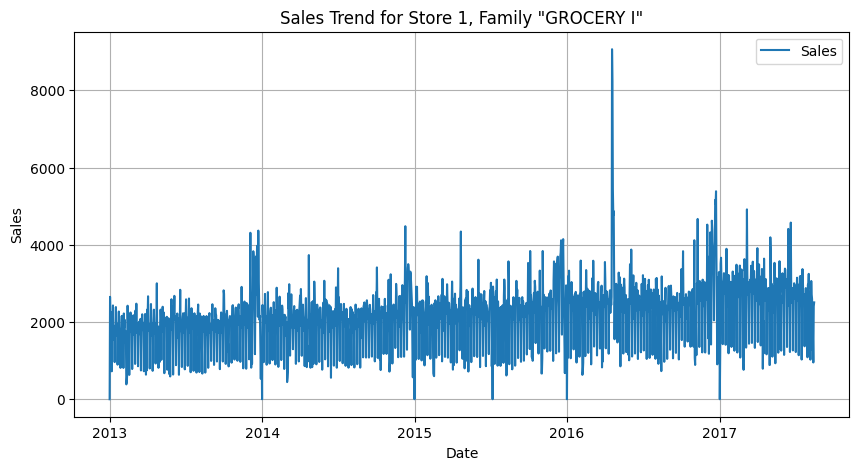

{'ADF Statistic': -4.150401045659741,
 'p-value': 0.0007985311957746648,
 'Critical Values': {'1%': -3.4342978282123258,
  '5%': -2.8632837412222885,
  '10%': -2.567698326213784}}

In [ ]:
# 데이터의 정상성을 파악하기 위해 시계열 데이터를 시각화하고 정상성 테스트를 진행

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Plot the sales data
plt.figure(figsize=(10, 5))
plt.plot(train_filtered['sales'], label='Sales')
plt.title(f'Sales Trend for Store {store_nbr}, Family "{family}"')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Perform the Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(train_filtered['sales'])
adf_results = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}
adf_results

시각화: 그래프에서 보듯이, 선택한 매장과 제품군에 대한 판매 데이터는 시계열적으로 분명한 변화 패턴을 보입니다.
ADF(확장 딕키-풀러) 테스트 결과:
ADF 통계량: -4.15
p-value: 0.0008 (통계적으로 매우 유의미함)
임계값: 1%, 5%, 10% 수준에서 각각 -3.43, -2.86, -2.57
p-value가 매우 낮고, ADF 통계량이 모든 임계값보다 작아 데이터가 정상성을 띄고 있다는 것을 나타냅니다. 이 데이터는 별도의 차분 없이 ARIMA 모델을 적용할 수 있을 것으로 보입니다.

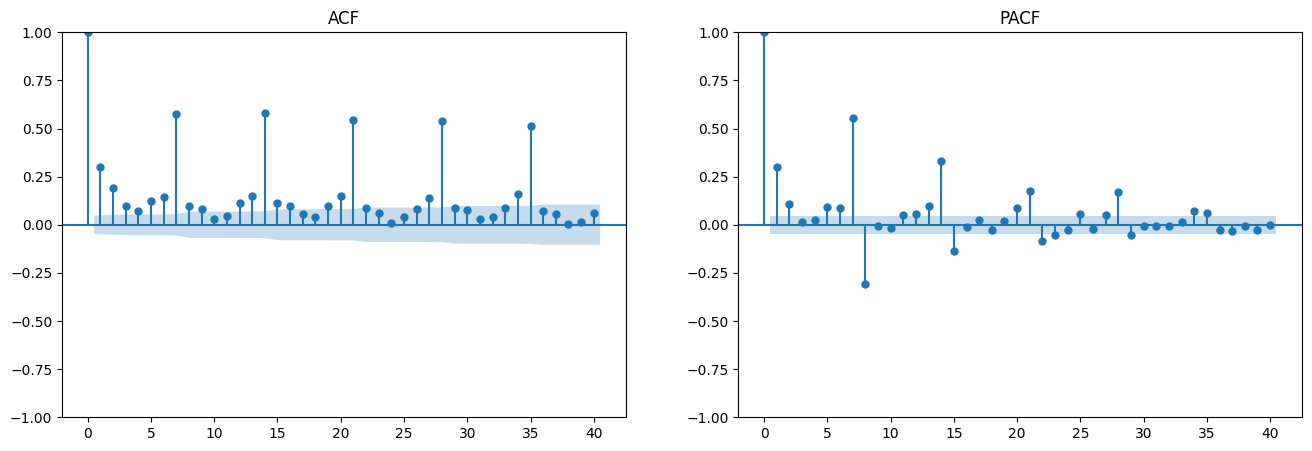

In [ ]:
# 적절한 ARIMA 모델의 매개변수 p, d, q를 선택하고 모델을 학습

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to help identify suitable values for p and q
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(train_filtered['sales'], ax=ax[0], lags=40, title="ACF")
plot_pacf(train_filtered['sales'], ax=ax[1], lags=40, title="PACF")
plt.show()

ACF와 PACF 플롯을 보면, 다음과 같은 모델 파라미터를 유추할 수 있습니다.

ACF (자기상관 함수):
시차 1에서 매우 높은 상관관계가 있으며 그 이후로 점차 감소합니다.
이를 통해 q 값으로 1 또는 2를 고려할 수 있습니다.

PACF (부분 자기상관 함수):
시차 1과 2에서 유의미한 값이 나타나며 이후로는 큰 상관관계가 없습니다.
이를 통해 p 값으로 1 또는 2를 고려할 수 있습니다.
결론:p=2, d=0, q=2

In [ ]:
# ARIMA(2, 0, 1) 모델을 훈련시켜 예측을 진행

from statsmodels.tsa.arima.model import ARIMA

# Define and fit the ARIMA model with parameters p=2, d=0, q=1
arima_model = ARIMA(train_filtered['sales'], order=(2, 0, 1))
arima_fitted = arima_model.fit()

# Model summary
arima_summary = arima_fitted.summary()
arima_summary

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1684
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -13433.009
Date:                Wed, 08 May 2024   AIC                          26878.018
Time:                        00:50:54   BIC                          26910.592
Sample:                             0   HQIC                         26890.083
                               - 1684                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2222.9660    168.762     13.172      0.000    1892.199    2553.733
ar.L1          0.2326      0.028      8.336      0.000       0.178       0.287
ar.L2          0.7621      0.027     27.818      0.000       0.708       0.816
ma.L1         -0.0558      0.021     -2.671      0.008      -0.097      -0.015
ma.L2         -0.8797      0.018    -49.644      0.000      -0.914      -0.845
sigma2      4.963e+05      1e+04     49.389      0.000    4.77e+05    5.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.46   Jarque-Bera (JB):              2576.30
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

상수항 (const): 모델에서 기본적으로 예측되는 평균 판매량은 약 2222.97로 나타났습니다.
AR 계수:
AR(1): 0.2325
AR(2): 0.7621
MA 계수:
MA(1): -0.0557
MA(2): -0.8796
분산 (sigma2): 496,600으로 모델의 오차 분산을 나타냅니다.

In [ ]:
#첫 번째 매장(Store 1)의 GROCERY I 제품군에 대해 ARIMA(2, 0, 2) 모델을 사용해 판매량을 예측

# Prepare the test data for the selected store and family
test_filtered = test[(test['store_nbr'] == store_nbr) & (test['family'] == family)]
test_filtered['date'] = pd.to_datetime(test_filtered['date'])
test_filtered = test_filtered.set_index('date').sort_index()

# Forecast the future sales for the test period
forecast_sales = arima_fitted.forecast(steps=len(test_filtered))

# Add the forecasted sales to the test dataset
test_filtered['sales'] = forecast_sales

# Display the first few rows of the updated test data
test_filtered.head()


<ipython-input-10-49860a19f968>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['date'] = pd.to_datetime(test_filtered['date'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,id,store_nbr,family,onpromotion,sales
date,,,,,
2017-08-16,3000900,1,GROCERY I,64,NaN
2017-08-17,3002682,1,GROCERY I,33,NaN
2017-08-18,3004464,1,GROCERY I,31,NaN
2017-08-19,3006246,1,GROCERY I,32,NaN
2017-08-20,3008028,1,GROCERY I,24,NaN


In [ ]:
# ARIMA 모델을 통해 test 데이터셋에 예측된 판매량을 추가

# Forecast the future sales for the test period
forecast_sales = arima_fitted.forecast(steps=len(test_filtered))

# Add the forecasted sales to the test dataset with appropriate date index
test_filtered['sales'] = forecast_sales.values

# Display the first few rows of the updated test data
test_filtered

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,id,store_nbr,family,onpromotion,sales
date,,,,,
2017-08-16,3000900,1,GROCERY I,64,2172.677084
2017-08-17,3002682,1,GROCERY I,33,2577.387420
2017-08-18,3004464,1,GROCERY I,31,2267.071817
2017-08-19,3006246,1,GROCERY I,32,2503.319412
2017-08-20,3008028,1,GROCERY I,24,2321.781226
2017-08-21,3009810,1,GROCERY I,26,2459.598145
2017-08-22,3011592,1,GROCERY I,27,2353.305372
2017-08-23,3013374,1,GROCERY I,41,2433.611029
2017-08-24,3015156,1,GROCERY I,44,2371.285152
